In [3]:
import pyvisa as visa
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
from scipy.signal import savgol_filter
from scipy.signal import find_peaks     


In [4]:

# le saco lo del channel 2 para que vaya más rápido
def cargar_datos_2(n, i, ruta, a):
    
    #n número de datos tomados +1
    # i número de medición -1 (empezando a contar desde 1)
    # sufijo para cada medición distinta

    columnas = [f'{j}' for j in range(1, n)]

    # Rutas a archivos
    señales_Ch1 = os.path.join(ruta, 'Mediciones_CH1.csv')
    tiempos_Ch1 = os.path.join(ruta, 'Tiempos_CH1.csv')
    unidades_escalas = os.path.join(ruta, 'Unidades y escala.csv')

    # Lectura de archivos
    data_señales_Ch1 = pd.read_csv(señales_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_tiempos_Ch1 = pd.read_csv(tiempos_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_unidades_escalas = pd.read_csv(unidades_escalas, delimiter=',', header=None, names=columnas)

    # Selección de columna
    col_name = str(i + 1)

    # Variables con sufijo personalizado
    globals()[f'tiempos1_{a}'] = data_tiempos_Ch1[col_name].values
    globals()[f'voltajes1_{a}'] = data_señales_Ch1[col_name].values

    escala_Ch1 = float(data_unidades_escalas[col_name].iloc[4])

    globals()[f'error_Ch1_{a}'] = escala_Ch1 * 10 / 256



/var/folders/rc/r38kbnms2_v7yd1z5kf1zx340000gn/T/ipykernel_11483/302906735.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_señales_Ch1 = pd.read_csv(señales_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
/var/folders/rc/r38kbnms2_v7yd1z5kf1zx340000gn/T/ipykernel_11483/302906735.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_tiempos_Ch1 = pd.read_csv(tiempos_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)


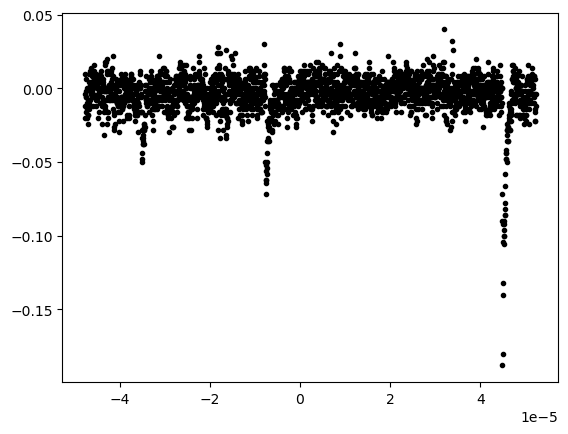

In [5]:
cargar_datos_2(1001,26, r"/Users/Mauri/Desktop/Labo 5/Conteo de fotones/31-10/Poisson r=3kOhm", "a")


plt.plot(tiempos1_a, voltajes1_a, ".k")
#plt.xlim(0,3e-5)
plt.show()

In [5]:





def análisis(n, ruta, h, dis, pro, i_graficado, x_min, x_max, graficar = True, Poisson = False):

    intensidades = []
    numero_de_picos = []

    for i in range(0, n-1):
        
        cargar_datos_2(n = n, i = i, ruta = ruta, a = "a")

        señal = (-1) * voltajes1_a

        peaks, properties = find_peaks(
                            señal,
                            height= h,        # altura mínima del pico
                            distance= dis,      # distancia mínima en puntos entre picos
                            prominence= pro    # "prominencia" mínima (cuán destacado es el pico)
                            )

        #intensidades = señal[peaks]  # estos son los valores negativos en la señal original
        intensidades.extend(señal[peaks])

        numero_de_picos.append(len(peaks))

    return intensidades, numero_de_picos

    if graficar:
        # Crear figura con dos subplots (1 fila, 2 columnas)
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # ancho 10, alto 4

        cargar_datos_2(n = n, i = i_graficado, ruta = ruta, a = "g")
    
        axs[0].plot(tiempos1_g, voltajes1_g, color='black')
        axs[0].set_xlim(x_min, x_max)
        axs[0].set_title('Ejemplo de una medición')
        axs[0].set_xlabel('Tiempo (s)')
        axs[0].set_ylabel('Amplitud')

        # --- Histograma 1: intensidades ---
        axs[1].hist(intensidades, bins=20, color='steelblue')
        axs[1].set_xlabel('Intensidad del pico')
        axs[1].set_ylabel('Frecuencia')
        axs[1].set_title('Distribución de intensidades')


        # Ajustar espacios entre gráficos
        plt.tight_layout()
        plt.show()


        if Poisson:
            # Crear una figura 2x2
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))

            # --- (0,0) Señal ---
            axs[0, 0].plot(tiempos1_g, voltajes1_g, color='black')
            axs[0, 0].set_title('Ejemplo de una medición')
            axs[0, 0].set_xlabel('Tiempo (s)')
            axs[0, 0].set_ylabel('Amplitud')

            # --- (0,1) Histograma de intensidades ---
            axs[0, 1].hist(intensidades, bins=15, color='steelblue')
            axs[0, 1].set_title('Histograma de intensidades')
            axs[0, 1].set_xlabel('Intensidad del pico')
            axs[0, 1].set_ylabel('Frecuencia')

            # --- (1,0) Histograma de cantidad de picos ---
            axs[1, 0].hist(numero_de_picos, bins=range(min(numero_de_picos), max(numero_de_picos)+2),
                        color='coral', edgecolor='black', align='left')
            axs[1, 0].set_title('Histograma de cantidad de picos por medición')
            axs[1, 0].set_xlabel('Cantidad de picos')
            axs[1, 0].set_ylabel('Frecuencia')

            # --- (1,1) lo dejamos vacío ---
            axs[1, 1].axis('off')

            # Ajustar distribución de subplots
            plt.tight_layout()
            plt.show()


        



In [ ]:
análisis(n = 101, ruta = '/Users/Mauri/Desktop/Labo 5/Conteo de fotones/31-10/ancho R=3kOhm', 
         h = 0.05, dis = 5, pro = 0.05, i_graficado = 3, x_min = -4e-5, x_max = 4e-5, graficar = True, Poisson = False)


Versión mucho más rápida

In [40]:

def cargar_datos(ruta, n):
    """Carga los archivos CSV una sola vez y devuelve DataFrames."""
    columnas = [f'{j}' for j in range(1, n)]

    data_señales = pd.read_csv(os.path.join(ruta, 'Mediciones_CH1.csv'), skiprows=3, header=None, names=columnas)
    data_tiempos = pd.read_csv(os.path.join(ruta, 'Tiempos_CH1.csv'), skiprows=3, header=None, names=columnas)
    data_unidades = pd.read_csv(os.path.join(ruta, 'Unidades y escala.csv'), header=None, names=columnas)

    return data_señales, data_tiempos, data_unidades


def analisis_rapido(n, ruta, h, dis, pro, i_graficado, x_min, x_max, graficar = True, Poisson = False):
    """Analiza todos los canales sin recargar archivos en cada iteración."""
    
    data_señales, data_tiempos, data_unidades = cargar_datos(ruta, n)

    escala = data_unidades.iloc[4].astype(float)  # escala por columna

    intensidades = []
    numero_de_picos = []

    for i in range(0, n-1):
        col_name = str(i + 1)

        # Señal y parámetros
        señal = (-1) * data_señales[col_name].values
        escala_i = escala[col_name]
        error = escala_i * 10 / 256

        # Detección de picos
        peaks, _ = find_peaks(señal, height=h, distance=dis, prominence=pro)
        intensidades.extend(señal[peaks])
        numero_de_picos.append(len(peaks))

        # Liberar memoria de arrays grandes explícitamente
        del señal, peaks


    if graficar:
        # Crear figura con dos subplots (1 fila, 2 columnas)
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # ancho 10, alto 4

        cargar_datos_2(n = n, i = i_graficado, ruta = ruta, a = "g")
        señal = voltajes1_g * (-1)
        peaks, _ = find_peaks(señal, height=h, distance=dis, prominence=pro)

        axs[0].plot(tiempos1_g, señal, label='Señal', color = 'indianred')
        axs[0].plot(tiempos1_g[peaks], señal[peaks], 'ro', label='Picos detectados')
        axs[0].legend()
        
        #axs[0].set_xlim(x_min, x_max)
        axs[0].axhline(y=h, color="cadetblue", linestyle="--", linewidth=1, label="Label vline")
        axs[0].set_title('Ejemplo medición')
        axs[0].set_xlabel('Tiempo [s]')
        axs[0].set_ylabel('Amplitud [V]')

        # --- Histograma 1: intensidades ---
        axs[1].hist(intensidades, density=True, bins=30, histtype='barstacked', alpha=0.7, color='teal', edgecolor='gray')
        axs[1].set_xlabel('Intensidad del pico')
        axs[1].set_ylabel('Frecuencia')
        axs[1].set_title('Distribución de intensidades')


        # Ajustar espacios entre gráficos
        plt.tight_layout()
        plt.show()


        if Poisson:

            fig, axs = plt.subplots(1, 1, figsize=(6, 3))
            
            # --- (1,0) Histograma de cantidad de picos ---
            axs.hist(numero_de_picos, density=True, bins=range(min(numero_de_picos), max(numero_de_picos)+2),
                    color='mediumblue', edgecolor='slateblue', align='left')
            axs.set_title('Cantidad de picos por medición')
            axs.set_xlabel('Cantidad de picos')
            axs.set_ylabel('Frecuencia')

            # Ajustar distribución de subplots
            plt.tight_layout()
            plt.show()


/var/folders/rc/r38kbnms2_v7yd1z5kf1zx340000gn/T/ipykernel_11664/2765456172.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_señales = pd.read_csv(os.path.join(ruta, 'Mediciones_CH1.csv'), skiprows=3, header=None, names=columnas)
/var/folders/rc/r38kbnms2_v7yd1z5kf1zx340000gn/T/ipykernel_11664/2765456172.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_tiempos = pd.read_csv(os.path.join(ruta, 'Tiempos_CH1.csv'), skiprows=3, header=None, names=columnas)
/var/folders/rc/r38kbnms2_v7yd1z5kf1zx340000gn/T/ipykernel_11664/302906735.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_señales_Ch1 = pd.read_csv(señales_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
/var/folders/rc/r38kbnms2_v7yd1z5kf1zx340000gn/T/ipykernel_11664/302906735.py:17: DtypeWarning: Columns (0) have mixed types. Speci

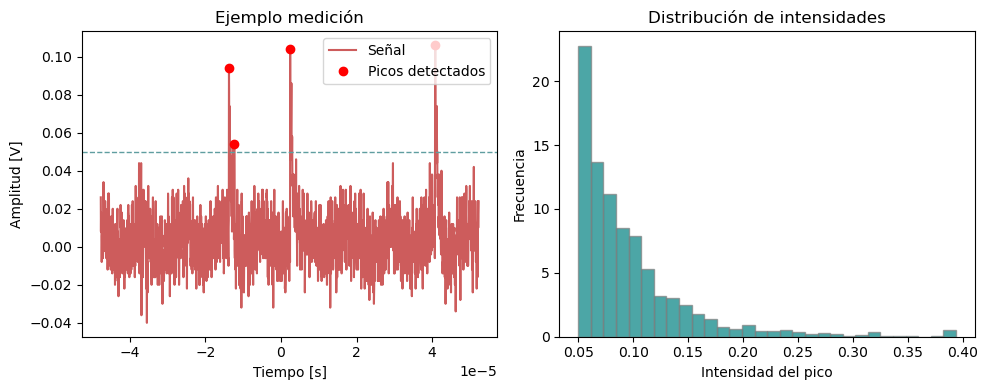

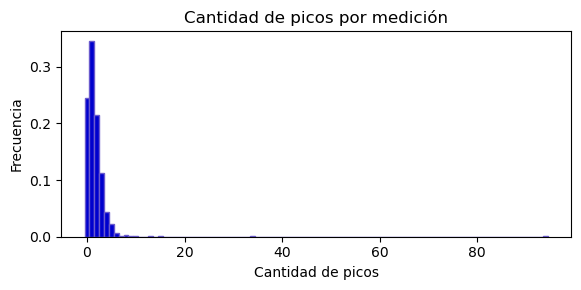

In [41]:
analisis_rapido(n = 1001, ruta = '/Users/Mauri/Desktop/Labo 5/Conteo de fotones/31-10/Poisson r=3kOhm', 
         h = 0.05, dis = 5, pro = 0.05, i_graficado = 5, x_min = -4e-5, x_max = 4e-5, graficar = True, Poisson = True)

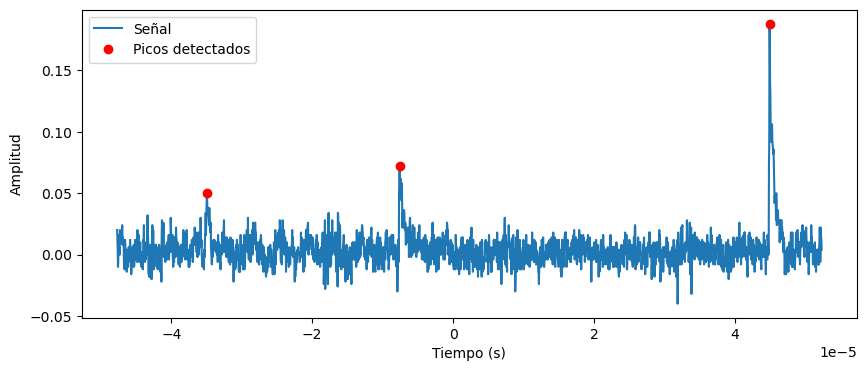

In [29]:

# --- 1. Detectar picos negativos ---
# Invertimos la señal
señal = (-1) * voltajes1_a

# find_peaks devuelve índices de los máximos en la señal invertida
#peaks, properties = find_peaks(señal, height=0.05)  # height define la altura mínima del pico

peaks, properties = find_peaks(
                    señal,
                    height= 0.05,        # altura mínima del pico
                    distance= 5,      # distancia mínima en puntos entre picos
                    prominence= 0.05    # "prominencia" mínima (cuán destacado es el pico)
                    )

intensidades = señal[peaks]  # estos son los valores negativos en la señal original

# --- 3. Graficar ---
plt.figure(figsize=(10,4))
plt.plot(tiempos1_a, señal, label='Señal')
plt.plot(tiempos1_a[peaks], señal[peaks], 'ro', label='Picos detectados')
plt.legend()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()


In [ ]:
           # --- Histograma 2: cantidad de picos por medición ---
            axs[1].hist(numero_de_picos, bins=range(min(numero_de_picos), max(numero_de_picos)+2), 
                        color='coral', edgecolor='black', align='left')
            axs[1].set_xlabel('Cantidad de picos detectados')
            axs[1].set_ylabel('Frecuencia')
            axs[1].set_title('Distribución de número de picos')




            # Crear una figura 2x2
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))

            # --- (0,0) Señal ---
            axs[0, 0].plot(tiempos1_g, voltajes1_g, color='black')
            axs[0, 0].set_title('Ejemplo de una medición')
            axs[0, 0].set_xlabel('Tiempo (s)')
            axs[0, 0].set_ylabel('Amplitud')

            # --- (0,1) Histograma de intensidades ---
            axs[0, 1].hist(intensidades, bins=15, color='steelblue')
            axs[0, 1].set_title('Histograma de intensidades')
            axs[0, 1].set_xlabel('Intensidad del pico')
            axs[0, 1].set_ylabel('Frecuencia')